## Introduction

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Top Selling Genre Analysis

In [4]:
q = '''
WITH us_purchases AS
    (
     SELECT il.* FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE c.country = 'USA'
    )
    
SELECT
    g.name,
    SUM(up.quantity) tracks_sold,
    CAST(SUM(up.quantity) AS float) / (SELECT COUNT(*) FROM us_purchases) percentage_sold
FROM us_purchases up
INNER JOIN track t ON t.track_id = up.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(q)

,name,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


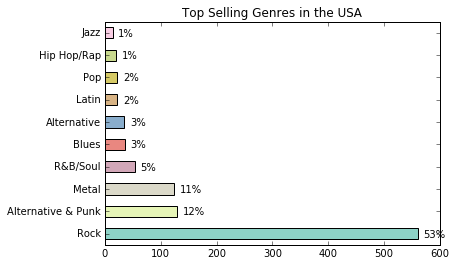

In [5]:
genre_sales_usa = run_query(q)
genre_sales_usa.set_index("name", drop=True, inplace=True)

cs=cm.Set3(np.arange(100)/14)
genre_sales_usa['tracks_sold'].plot.barh(
    title="Top Selling Genres in the USA",
    color=cs
    )

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

According to the results above, it would be recommended to purchase albums by Red Tone, Slim Jim Bites, and Meteor and the Girls. Also, any albums in the Rock genre would be recommended for the future.

## Analyzing Sales by Employee

In [6]:
q = '''
SELECT
    e.first_name || ' ' || e.last_name sales_agent,
    e.hire_date,
    SUM(i.total) total_sales
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY 1
ORDER BY 3 DESC
LIMIT 10;
'''
run_query(q)

,sales_agent,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


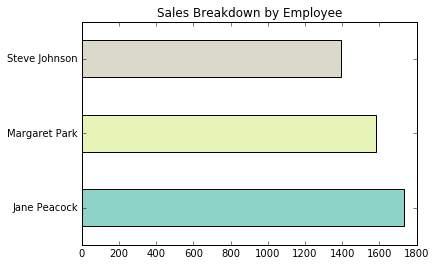

In [7]:
employee_sales = run_query(q)
employee_sales.set_index('sales_agent', drop=True, inplace=True)

cs=cm.Set3(np.arange(100)/14)
employee_sales['total_sales'].plot.barh(
    title='Sales Breakdown by Employee',
    color=cs
    )

plt.ylabel('')

Although Steve Johnson has the lowest aggregate sales, he is the newest employee which could explain the difference.

## Analyzing Sales by Country

In [8]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
     SELECT
         country,
         COUNT(DISTINCT customer_id) customers,
         SUM(unit_price) total_sales,
         SUM(unit_price) / COUNT(DISTINCT customer_id) customer_lifetime_value,
         SUM(unit_price) / COUNT(DISTINCT invoice_id) average_order,
         CASE
             WHEN country = 'Other' THEN 1
             ELSE 0
         END AS sort
     FROM country_or_other
     GROUP BY 1
     ORDER BY sort, 3 DESC
    );   
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales by Country

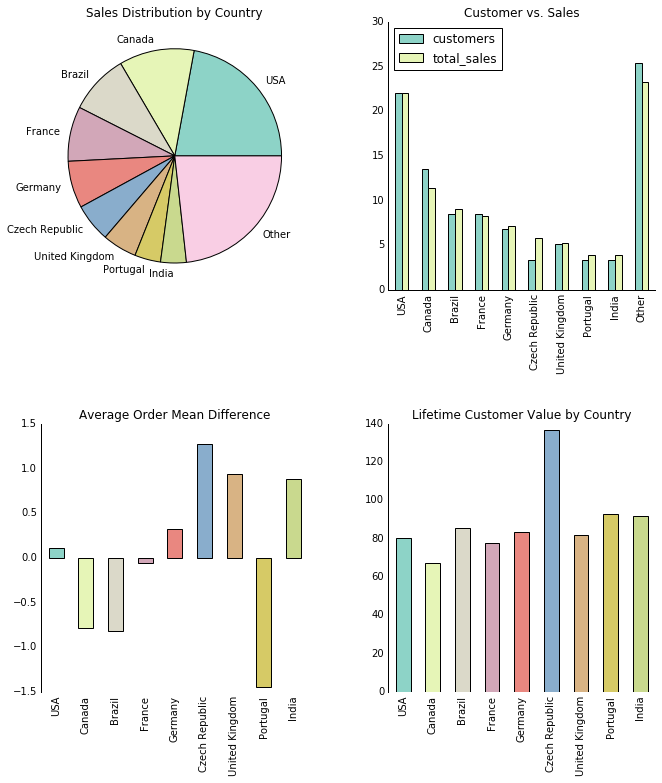

In [9]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)

cs=cm.Set3(np.arange(100)/14)

fig = plt.figure(figsize=(11,12))
fig.subplots_adjust(hspace=.5, wspace=.3)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Top Left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    title = 'Sales Distribution by Country',
    colors=cs
    )

# Top Right
cvd_cols = ['customers', 'total_sales']
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name=''

for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    title='Customer vs. Sales',
    color=cs
    )
ax2.tick_params(top='off', right='off', left='off', bottom='off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Bottom Left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name =''
mean_difference = avg_order - avg_order.mean()
mean_difference.drop('Other', inplace=True)
mean_difference.plot.bar(
    ax=ax3,
    title='Average Order Mean Difference',
    color=cs
    )
ax3.tick_params(top='off', right='off', left='off', bottom='off')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

# Bottom Right
lifetime = country_metrics['customer_lifetime_value'].copy()
lifetime.drop('Other', inplace=True)
lifetime.index.name=''
lifetime.plot.bar(
    ax=ax4,
    title='Lifetime Customer Value by Country',
    color=cs
    )
ax4.tick_params(top='off', right='off', left='off', bottom='off')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)

plt.show()

The Czech Republic has the highest Lifetime Customer Value and has the highest sales per customer as well. This could indicate potential for growth. USA, Canada, and Brazil are the largest markets respectively; collectively, they comprise over 1/3 market share.

## Album Sales Breakdown

In [10]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "Yes"
             ELSE "No"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Since over 80% of customers buy single or assorted tracks it may not make sense to target full album sales as opposed to top tracks instead.